In [1]:
import pandas as pd
import tensorflow as tf
df = pd.read_csv('water_leak_detection_1000_rows.csv')
print(df.head())
print(df.info())


             Timestamp Sensor_ID  Pressure (bar)  Flow Rate (L/s)  \
0  2024-01-01 00:00:00      S007        3.694814        77.515218   
1  2024-01-01 00:05:00      S007        2.587125       179.926422   
2  2024-01-01 00:10:00      S002        2.448965       210.130823   
3  2024-01-01 00:15:00      S009        2.936844       141.777934   
4  2024-01-01 00:20:00      S003        3.073693       197.484633   

   Temperature (°C)  Leak Status  Burst Status  
0         21.695365            0             0  
1         19.016725            0             0  
2         10.011681            1             0  
3         12.092408            0             0  
4         17.001443            0             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp         1000 non-null   object 
 1   Sensor_ID         1000 non-null   object

In [2]:
print(df.isnull().sum())


Timestamp           0
Sensor_ID           0
Pressure (bar)      0
Flow Rate (L/s)     0
Temperature (°C)    0
Leak Status         0
Burst Status        0
dtype: int64


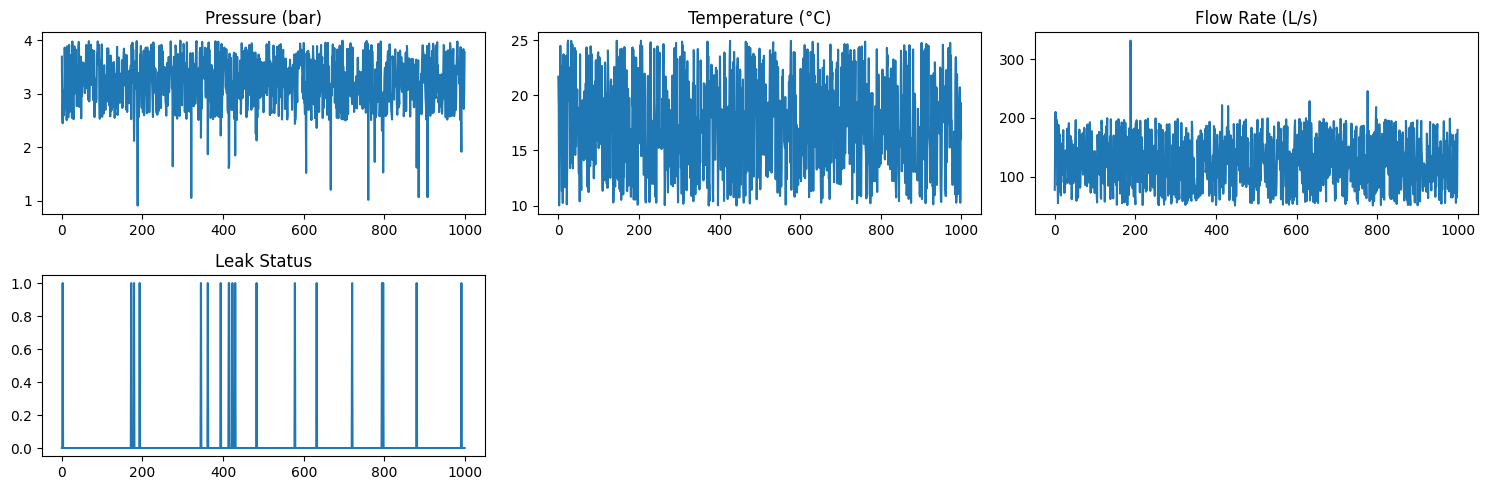

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(2, 3, 1)
plt.plot(df['Pressure (bar)'])
plt.title('Pressure (bar)')

plt.subplot(2, 3, 2)
plt.plot(df['Temperature (°C)'])
plt.title('Temperature (°C)')

plt.subplot(2, 3, 3)
plt.plot(df['Flow Rate (L/s)'])
plt.title('Flow Rate (L/s)')

plt.subplot(2, 3, 4)
plt.plot(df['Leak Status'])
plt.title('Leak Status')

plt.tight_layout()
plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler_press = MinMaxScaler()
scaler_temp = MinMaxScaler()
scaler_flow = MinMaxScaler()

df_scaled = df.copy()

df_scaled['Pressure (bar)'] = scaler_press.fit_transform(df[['Pressure (bar)']])
df_scaled['Temperature (°C)'] = scaler_temp.fit_transform(df[['Temperature (°C)']])
df_scaled['Flow Rate (L/s)'] = scaler_flow.fit_transform(df[['Flow Rate (L/s)']])


In [5]:
import numpy as np

X = df_scaled[['Pressure (bar)', 'Temperature (°C)', 'Flow Rate (L/s)']] 
y = df['Leak Status']
print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (1000, 3)
y shape: (1000,)


In [6]:
import numpy as np


"""def create_sequences(data, window_size=30):
    X, y = [], []
    data = np.array(data)

    for i in range(window_size, len(data) - 2):
        moyenne_30 = np.mean(data[i - window_size:i])
        xl = list()
        for j in range(1):
            xl.append(0-data[i - (j+1)])
            
        target = data[i] 

        X.append([ l for l in xl])
        y.append(target)
    lenX =  1
    return np.array(X), np.array(y),lenX
"""





'def create_sequences(data, window_size=30):\n    X, y = [], []\n    data = np.array(data)\n\n    for i in range(window_size, len(data) - 2):\n        moyenne_30 = np.mean(data[i - window_size:i])\n        xl = list()\n        for j in range(1):\n            xl.append(0-data[i - (j+1)])\n            \n        target = data[i] \n\n        X.append([ l for l in xl])\n        y.append(target)\n    lenX =  1\n    return np.array(X), np.array(y),lenX\n'

In [7]:
def create_sequences(data, window_size=30):
    X, y = [], []
    data = np.array(data)

    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        target = data[i]

        
        X.append(window)
        y.append(target)
       

    return np.array(X), np.array(y), window_size

In [8]:
import tensorflow as tf

# List physical devices
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU detected:", physical_devices)
    # Chỉ bật memory growth cho GPU đầu tiên
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    print("Using GPU:", physical_devices[0])
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    print("Using GPU:", physical_devices[0])
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

def model_LSTM(X_train, X_test, y_train, y_test, seq_length,lenX):
    model = Sequential([
    LSTM(100, activation='tanh', input_shape=(lenX, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(100, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

    model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)
      
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model




In [12]:
window_size = 30
X_flow,y_flow,lenX = create_sequences(X["Flow Rate (L/s)"], window_size)
X_temp,y_temp,lenX = create_sequences(X["Temperature (°C)"], window_size)
X_press,y_press,lenX = create_sequences(X["Pressure (bar)"], window_size)

In [13]:
def split(s,X,y):
    split = int(s * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print("Train shape:", X_train.shape, y_train.shape)
    print("Test shape:", X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [14]:
s = 0.8
X_train_flow,X_test_flow,y_train_flow,y_test_flow = split(s,X_flow,y_flow)
X_train_temp,X_test_temp,y_train_temp,y_test_temp = split(s,X_temp,y_temp)
X_train_press,X_test_press,y_train_press,y_test_press = split(s,X_press,y_press)


Train shape: (776, 30) (776,)
Test shape: (194, 30) (194,)
Train shape: (776, 30) (776,)
Test shape: (194, 30) (194,)
Train shape: (776, 30) (776,)
Test shape: (194, 30) (194,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
39/3

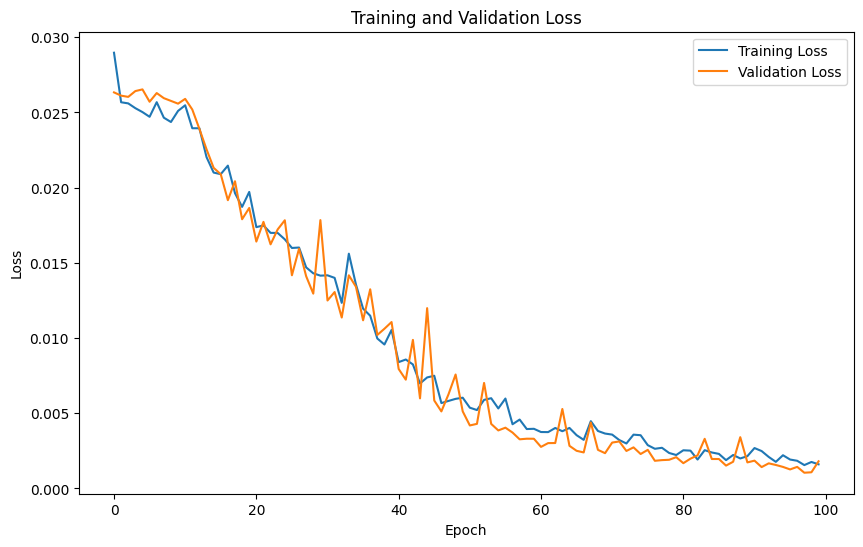

In [15]:
model_flow = model_LSTM(X_train_flow,X_test_flow,y_train_flow,y_test_flow,window_size,lenX)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 100)           40800     
                                                                 
 dropout_2 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
39

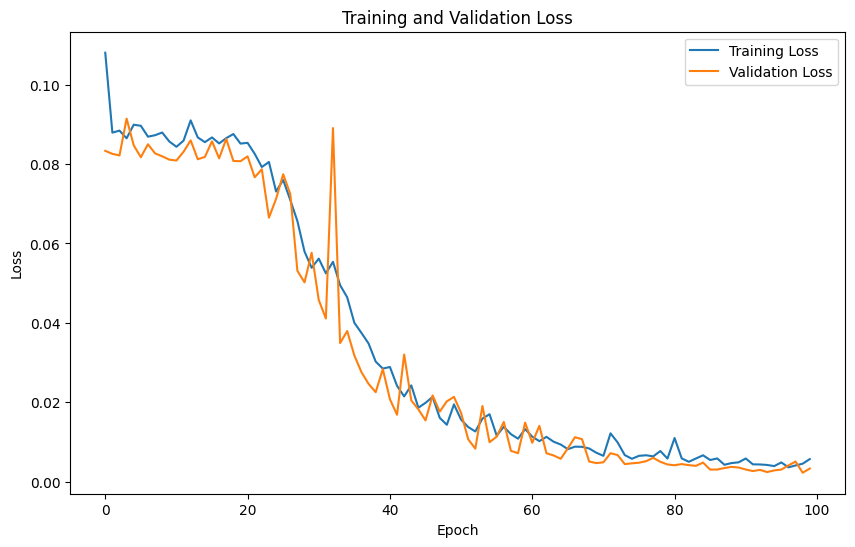

In [16]:
model_temp = model_LSTM(X_train_temp,X_test_temp,y_train_temp,y_test_temp,window_size,lenX)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 100)           40800     
                                                                 
 dropout_4 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
39

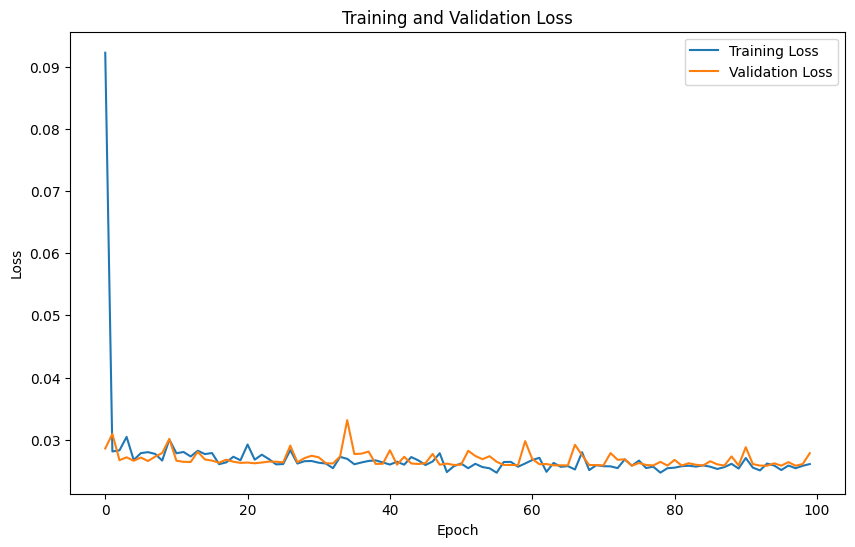

In [17]:
model_press = model_LSTM(X_train_press,X_test_press,y_train_press,y_test_press,window_size,lenX)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


y_pred_flow = model_flow.predict(X_test_flow)
y_pred_temp = model_temp.predict(X_test_temp)
y_pred_press = model_press.predict(X_test_press)



7/7 [==============================] - 1s 12ms/step


In [19]:
def lossFunction(y_test,y_pred,name):
    print("-"*15)
    print(name)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
        


In [20]:
aug = lambda x,coff : (np.mean(x)-x)*coff+np.mean(x)

In [30]:

y_pred_flow = aug(y_pred_flow,-1)
y_pred_temp =aug(y_pred_temp,-1)
y_pred_press =aug(y_pred_press,-15)

In [31]:
lossFunction(y_test_flow,y_pred_flow,"debit")
lossFunction(y_test_temp,y_pred_temp,"tempurature")
lossFunction(y_test_press,y_pred_press,"pression")

---------------
debit
MSE: 0.0017
MAE: 0.0360
RMSE: 0.0417
---------------
tempurature
MSE: 0.0035
MAE: 0.0491
RMSE: 0.0593
---------------
pression
MSE: 0.0446
MAE: 0.1684
RMSE: 0.2113


In [32]:
import matplotlib.pyplot as plt
def affiche(y_test,y_pred,title):

    plt.figure(figsize=(15,5))
    plt.plot(y_test, label=f'Actual {title}')
    plt.plot(y_pred, label=f'Predicted {title}')
    plt.title(f'Actual vs Predicted {title}')
    plt.xlabel('Temps')
    plt.ylabel('value')
    plt.legend()
    plt.show()

    residuals = y_test - y_pred.flatten()

    plt.figure(figsize=(10,4))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.title("Distribution des erreurs (résidus)")
    plt.xlabel("Erreur")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()

In [33]:
y_pred_flow_denorm = scaler_flow.inverse_transform(y_pred_flow.reshape(-1, 1))
y_test_flow_denorm = scaler_flow.inverse_transform(y_test_flow.reshape(-1, 1))

y_pred_temp_denorm = scaler_temp.inverse_transform(y_pred_temp.reshape(-1, 1))
y_test_temp_denorm = scaler_temp.inverse_transform(y_test_temp.reshape(-1, 1))

y_pred_press_denorm = scaler_press.inverse_transform(y_pred_press.reshape(-1, 1))
y_test_press_denorm = scaler_press.inverse_transform(y_test_press.reshape(-1, 1))

debit


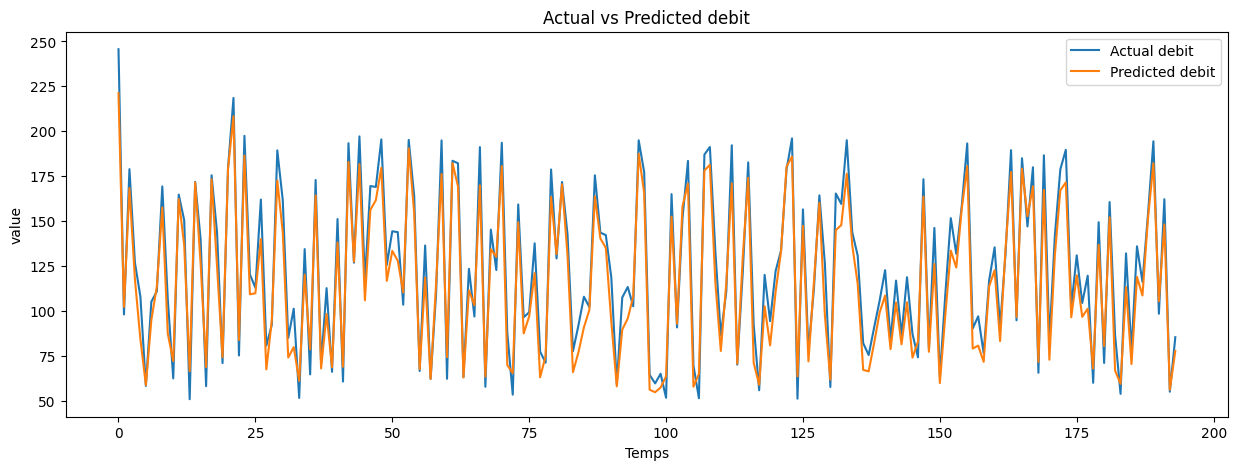

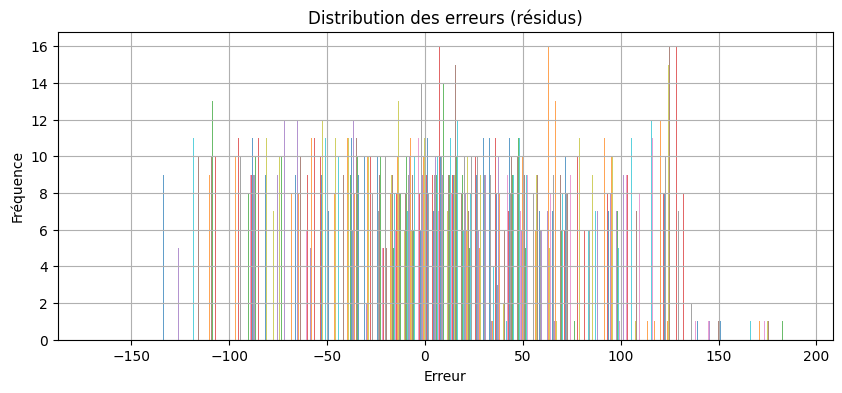

tempurature


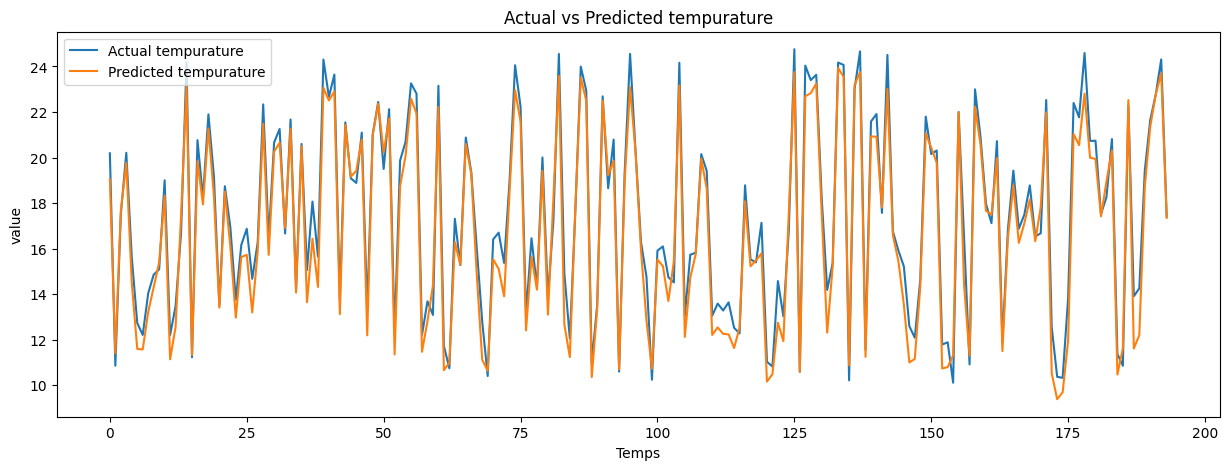

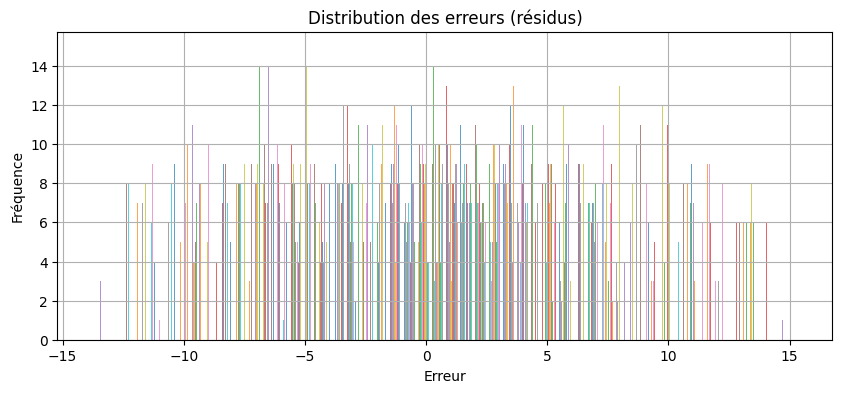

pression


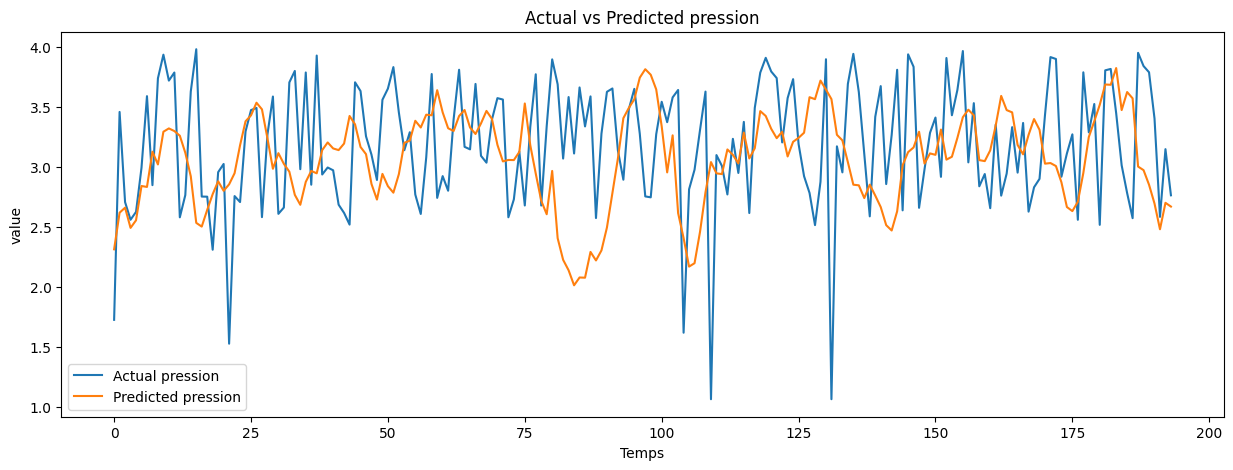

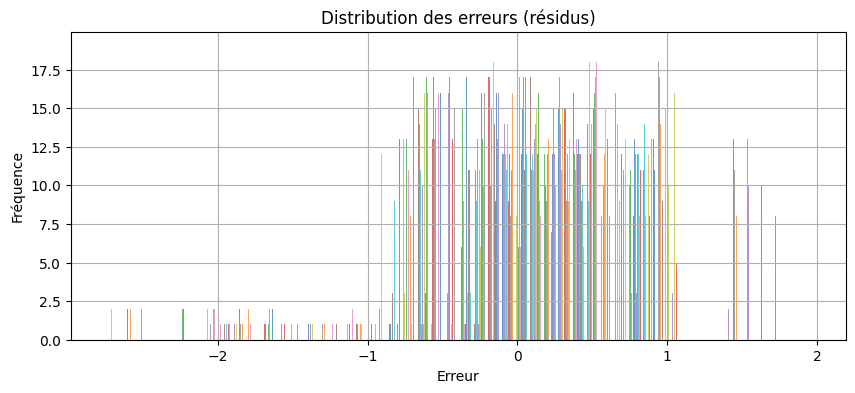

In [34]:


print("debit")
affiche(y_test_flow_denorm, y_pred_flow_denorm,"debit")

print("tempurature")
affiche(y_test_temp_denorm, y_pred_temp_denorm,"tempurature")

print("pression")
affiche(y_test_press_denorm, y_pred_press_denorm,"pression")



In [35]:
split = int(0.6 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (600, 3) (600,)
Test shape: (400, 3) (400,)


In [53]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                    param_grid,
                    cv=3,
                    scoring='accuracy')

grid.fit(X_train, y_train)



c:\Users\MSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:12] WARNING: C:\actions-runne

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model_xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)


print("Accuracy:", acc)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.985
Confusion Matrix:
 [[391   3]
 [  3   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       394
           1       0.50      0.50      0.50         6

    accuracy                           0.98       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.98      0.98      0.98       400



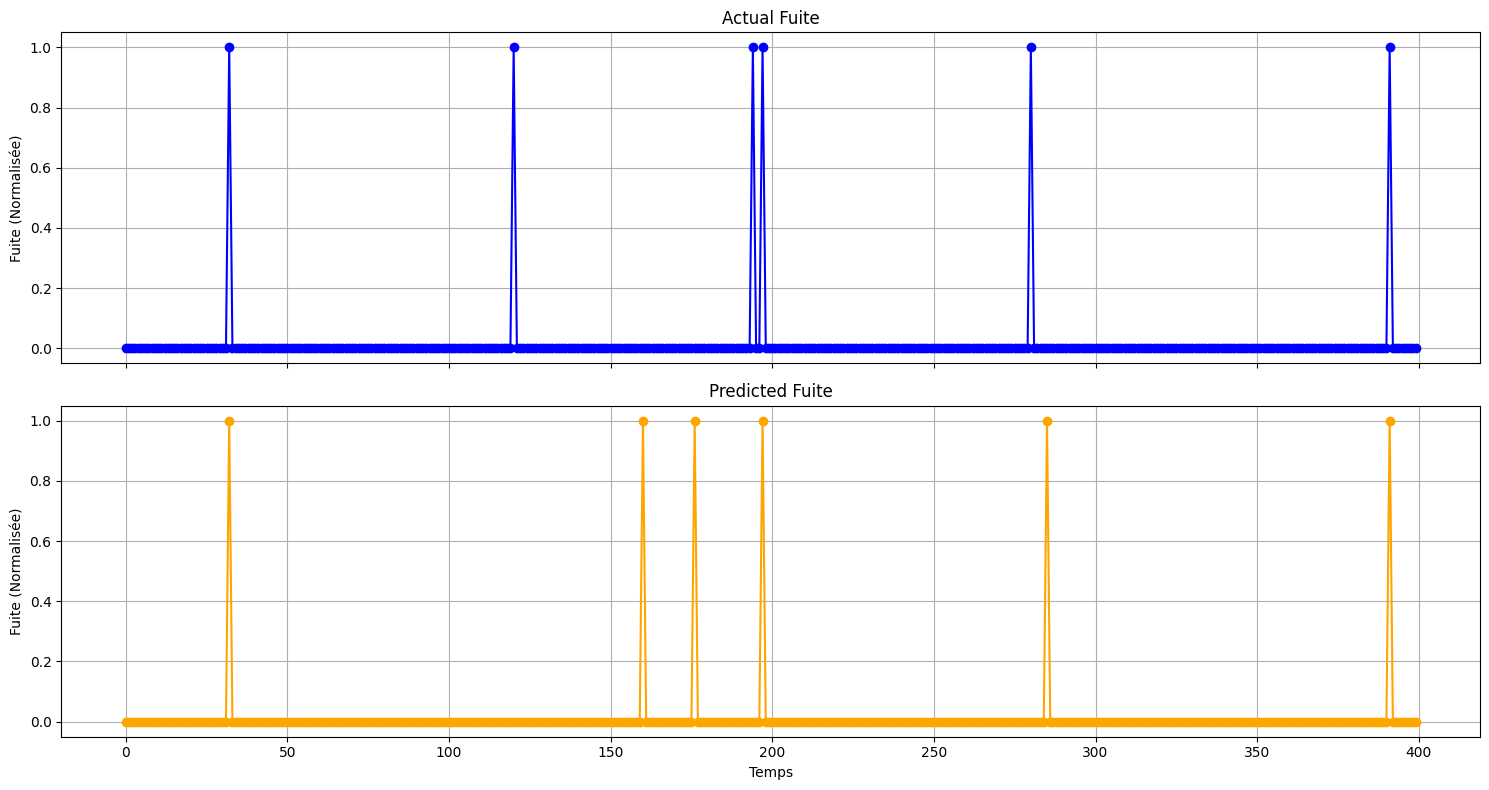

In [55]:
import matplotlib.pyplot as plt
import numpy as np  

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)


axs[0].plot(np.array(y_test), marker='o', color='blue')
axs[0].set_title('Actual Fuite')
axs[0].set_ylabel('Fuite (Normalisée)')
axs[0].grid(True)


axs[1].plot(np.array(y_pred), marker='o', color='orange')
axs[1].set_title('Predicted Fuite')
axs[1].set_xlabel('Temps')
axs[1].set_ylabel('Fuite (Normalisée)')
axs[1].grid(True)

plt.tight_layout()
plt.show()
